In [177]:
import numpy as np
import networkx as nx
import random
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np


class NodeLabel:
    def __init__(self, start, end, copy_number):
        self.start = start
        self.end = end
        self.copy_number = copy_number
    
    def get_event(self):
        return (self.start, self.end)
    
    def to_string(self):
        return "(" + str(self.start) + "," + str(self.end) + ") CN:" + str(self.copy_number)
    
    def overlaps(self, node_label):
        return (self.start >= node_label.start and self.start < node_label.end)\
                or (self.end > node_label.start and self.end < node_label.end)
            
class CNSampler:
    #should not contain CN=2
    def __init__(self, CN_to_weight, CN_to_sd):
        self.CN_to_weight = CN_to_weight
        sum_ = sum(list(CN_to_weight.values()))
        for key in self.CN_to_weight.keys():
            self.CN_to_weight[key] = self.CN_to_weight[key] / sum_
        self.CN_to_sd = CN_to_sd
        self.NEUTRAL_CN = 2 
        
    def sample_CN(self):
        return np.random.choice(list(self.CN_to_weight.keys()), 1, p = list(self.CN_to_weight.values()))[0]
    
    def sample_corrected_count(self, count): 
        cc = count + np.random.normal(0, self.CN_to_sd[int(count)], 1)
        while cc < 0:
            cc = count + np.random.normal(0, self.CN_to_sd[int(count)], 1)
        return cc

In [178]:
class TreeGenerator:
    def __init__(self, cn_sampler):
        self.cn_sampler = cn_sampler
        
    def generate_random_tree(self, no_loci, tree_size):
        tree_nodes_list = self.__sample_node_labels(tree_size, no_loci)
        tree = self.__random_tree(tree_nodes_list)
        while not self.__check_valid(tree):
            tree_nodes_list = self.__sample_node_labels(tree_size, no_loci)
            tree = self.__random_tree(tree_nodes_list)
        return tree
    
    def __sample_node_label(self, labels):
        norming_constant = 0
        for z in labels:
            norming_constant += np.exp(0.1 * (z[0] - z[1]))
        while True:
            label = random.sample(labels, 1)[0]
            if np.random.uniform() < np.exp(0.1 * (label[0] - label[1])) / norming_constant:
                return label

    def __sample_node_labels(self, tree_size, no_loci):
        candidates = list(filter(lambda x: x[0] < x[1], [(a, b) for a in range(0, no_loci) for b in range(0, no_loci)]))
        result = list()
        for n in range(0, tree_size):
            label = self.__sample_node_label(candidates)
            candidates.remove(label)
            result.append(NodeLabel(label[0], label[1], self.cn_sampler.sample_CN()))
        result.insert(0, NodeLabel(0, 0, self.cn_sampler.NEUTRAL_CN))
        return result
    
    def __random_tree(self, nodes):
        tree = nx.DiGraph()
        bit_map = np.zeros(len(nodes))
        bit_map[0] = 1
        visited = 1
        current_node = 0
        while len(nodes) > visited:
            new_node = random.sample(range(0, len(nodes)), 1)[0]
            if bit_map[new_node] == 0.0:
                bit_map[new_node] = 1.0
                tree.add_edge(nodes[current_node], nodes[new_node])
                visited += 1
            current_node = new_node
        return tree
    
    def __check_valid(self, tree):
        for node in tree:
            if node.copy_number == 0:
                children = [x[1] for x in list(nx.edge_dfs(tree,list(tree.nodes)[0]))]
                for c in children:
                    if c.copy_number > 0 and node.overlaps(c):
                        return False
        return True

In [179]:
class CountsGenerator:
    def __init__(self, cn_sampler):
        self.cn_sampler = cn_sampler
        
    def generate_data(self, no_loci, tree, no_of_cells):
        counts = np.zeros([0, no_loci], dtype=np.float64)
        
        node_to_counts = self.__fill_node_to_counts(tree, no_loci)
        
        attachment_probs = np.random.dirichlet(np.ones(len(tree.nodes) - 1)).transpose()
        attachment = []
        
        for cell in range(0, no_of_cells):
            attachment_node = random.choices(list(tree.nodes)[1:], k=1, weights=list(attachment_probs))[0]
            counts = np.vstack([counts, node_to_counts[attachment_node]])
            attachment.append(attachment_node.get_event())
        
        corrected_counts = self.__add_noise_to_counts(counts)
        diff_matrix = self.__create_diff_matrix(corrected_counts)
        return counts, attachment, corrected_counts, diff_matrix
    
    def __fill_node_to_counts(self, tree, no_loci):
        counts = np.zeros([1, no_loci], dtype=np.float64)
        counts.fill(self.cn_sampler.NEUTRAL_CN)
        node_to_counts = {}
        
        for node in tree:
            path = nx.shortest_path(tree, list(tree.nodes)[0], node)
            node_counts = np.copy(counts)
            for i in range(0, len(path)):
                ancestor = path[i]
                for j in range(ancestor.start, ancestor.end):
                    node_counts[0, j] = ancestor.copy_number
            node_to_counts[node] = node_counts    
        return node_to_counts
    
    def __add_noise_to_counts(self, counts):
        cc = np.copy(counts)
        for i in range(0, counts.shape[0]):
            for j in range(0, counts.shape[1]):
                cc[i,j] = self.cn_sampler.sample_corrected_count(counts[i,j])
        return cc
    
    def __create_diff_matrix(self, corrected_counts):
        diffs = np.copy(corrected_counts)
        
        for cell in range(0, diffs.shape[0]):
            for loci in range(0, diffs.shape[1]):
                if loci == 0:
                    diffs[cell, loci] = np.abs(corrected_counts[cell, loci] - self.cn_sampler.NEUTRAL_CN)
                else:
                    diffs[cell, loci] = np.abs(corrected_counts[cell, loci] - corrected_counts[cell, loci - 1])
        return diffs

In [180]:
cn_s = \
    CNSampler({0:0.020240121,1: 0.203724532,2: 0.361479297,3: 0.050340118,4: 0.038828672,5: 0.005309126,6: 0.0079,7: 0.00141,8: 0.293, 9: 0.017100587},
              {0:0.449,1: 0.116,2: 0.187,3: 0.114,4: 0.279,5: 0.0957,6: 0.4833,7: 0.2760,8: 6.15780,9: 4.72105270})

In [181]:
d = TreeGenerator(cn_s)

In [187]:
tree = d.generate_random_tree(40, 20)
dd = CountsGenerator(cn_s)
data = dd.generate_data(40, tree, 200)

ccs = data[2]
ccs = ccs.flatten()
diffs = data[3]
diffs = diffs.flatten()

In [188]:
#Plot the ground truth tree
plt.figure(3, figsize=(12,12))
pos = graphviz_layout(tree, prog = "dot")
nx.draw(tree, pos = pos, with_labels=True, node_color = "grey", node_size = 60, verticalalignment = "bottom",
       font_size=20, edge_color="grey", font_color="green")
plt.show()

FileNotFoundError: [WinError 2] "dot" not found in path.

<Figure size 864x864 with 0 Axes>

(array([5.07335505e-03, 1.13819618e-01, 8.88940037e-02, 1.02856759e+00,
        9.85995525e-02, 8.60264552e-03, 7.94090356e-03, 1.12496134e-02,
        1.22422263e-01, 4.36749696e-02, 3.81604532e-02, 2.86754851e-02,
        1.47789038e-02, 1.10290327e-02, 8.82322618e-03, 1.12496134e-02,
        1.21319360e-02, 1.16907747e-02, 9.04380683e-03, 8.82322618e-03,
        9.04380683e-03, 8.82322618e-03, 6.61741963e-03, 7.72032290e-03,
        5.29393571e-03, 5.29393571e-03, 5.29393571e-03, 4.63219374e-03,
        3.97045178e-03, 4.63219374e-03, 3.97045178e-03, 1.54406458e-03,
        2.64696785e-03, 2.20580654e-03, 2.42638720e-03, 1.10290327e-03,
        1.10290327e-03, 1.10290327e-03, 8.82322618e-04, 6.61741963e-04,
        1.10290327e-03, 2.20580654e-04, 0.00000000e+00, 4.41161309e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.20580654e-04,
        0.00000000e+00, 4.41161309e-04]),
 array([1.44082524e-03, 5.68126967e-01, 1.13481311e+00, 1.70149925e+00,
        2.26818539e+00

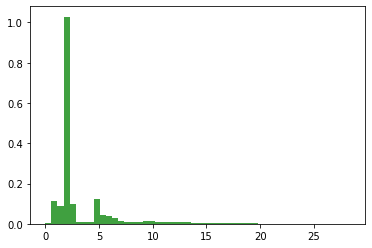

In [189]:
 plt.hist(ccs, 50, density=True, facecolor='g', alpha=0.75)

(array([1.41246814e+00, 1.03177774e-01, 3.48669718e-02, 2.27702673e-02,
        1.75520810e-02, 2.63281216e-02, 3.13091175e-02, 3.48669718e-02,
        2.94115953e-02, 1.61289393e-02, 1.44686073e-02, 1.18595142e-02,
        1.37570365e-02, 1.04363725e-02, 1.13851336e-02, 9.48761137e-03,
        1.09107531e-02, 9.01323080e-03, 8.77604052e-03, 9.48761137e-03,
        6.16694739e-03, 5.92975711e-03, 6.64132796e-03, 5.69256682e-03,
        4.50661540e-03, 4.03223483e-03, 4.74380569e-03, 3.08347370e-03,
        2.60909313e-03, 1.89752227e-03, 2.13471256e-03, 3.08347370e-03,
        1.18595142e-03, 9.48761137e-04, 9.48761137e-04, 1.18595142e-03,
        9.48761137e-04, 0.00000000e+00, 7.11570853e-04, 4.74380569e-04,
        4.74380569e-04, 4.74380569e-04, 2.37190284e-04, 2.37190284e-04,
        2.37190284e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.37190284e-04, 2.37190284e-04]),
 array([8.74093458e-06, 5.27011777e-01, 1.05401481e+00, 1.58101785e+00,
        2.10802089e+00

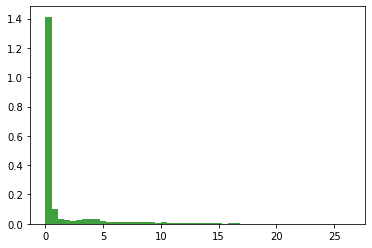

In [190]:
 plt.hist(diffs, 50, density=True, facecolor='g', alpha=0.75)